# LINK TO GITHUB: [Ran+Shany Repo](https://github.com/RyanWri/Afeka_DL_course_labs/tree/main/src/task_2)

**All our code is organized, you can find task2 in src/task_2 directory**

In [1]:
import os
import sys
import asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nest_asyncio
import json
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns


In [2]:
# Allow nested use of asyncio.run()
nest_asyncio.apply()

**Next Cell is for Import readibility**

In [3]:
# Prepend the src directory to the PYTHONPATH
sys.path.insert(0, os.path.abspath(os.getcwd()))

# Verify that the path has been added
print(sys.path[0])

c:\Afeka\Afeka_DL_course_labs


# 1 Use the dataset from UCI Machine Learning Repository
**We read the data and split it into 10 different chunks for faster reading, data files located in src/task_2/data directory**
<br>*Asyncio is an asynchornous library for fast processing time*

In [4]:
from src.task_2.eda.eda import load_and_process_chunk

async def process_data_parallel():
    rootdir = os.path.join(os.getcwd(), "src", "task_2", "data")

    # Traverse Data Directory and get paths to all chunk files
    file_names = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            file_names.append(os.path.join(subdir, file))
    
    # Load and process each chunk
    tasks = [load_and_process_chunk(file) for file in file_names]
    results = await asyncio.gather(*tasks)

    # Concatenate all chunks into a single DataFrame
    full_df = pd.concat(results)
    return full_df

# Run the asynchronous processing
full_df = asyncio.run(process_data_parallel())

# 2. Perform Exploratory Data Analysis (EDA) of the dataset

In [5]:
# Display the first few rows of the dataset
display(full_df.head())

# Summary statistics
display(full_df.describe())

# Display information
display(full_df.info())

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.083262e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.021964e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,5.578000e+00,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2008-12-06 07:12:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.1 MB


None

Creating a new feature by converting the Global active power from KW to W/h

In [5]:
# Convert kilowatt to watt hourly and divide by 60 to represent hourly data
full_df['Global_active_power_wh'] = full_df['Global_active_power'] * 1000 / 60

In [6]:
# Create a new feature: kilowatt per hour minus sub_metering_1, sub_metering_2, sub_metering_3
full_df['active_energy_without_subs'] = full_df['Global_active_power_wh']-full_df['Sub_metering_1']-full_df['Sub_metering_2']-full_df['Sub_metering_3']

In [7]:
# Resample to hourly intervals
df_hourly = full_df.resample('h').mean()
df_hourly = df_hourly.dropna()

In [16]:
# Create lagged feature for Global_active_power
df_hourly['Global_active_power_lag1'] = df_hourly['Global_active_power_wh'].shift(1)

# Drop rows with NaN values created by the shift operation
df_hourly = df_hourly.dropna()

# Define the target variable and features
features = ['Global_active_power_wh','active_energy_without_subs', 'Global_active_power_lag1']
target = 'Global_active_power'

def create_sequences(data, sequence_length, features, label):
    sequences = []
    targets = []
    for i in range(0, len(data) - sequence_length, sequence_length):
        seq = data[features].iloc[i:i + sequence_length].values
        label = data[target].iloc[i + sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

sequence_length = 60
sequences, targets = create_sequences(df_hourly, sequence_length, features, target)

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

scaler_y = MinMaxScaler()

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


In [18]:
import tensorflow as tf
from keras import Sequential
from keras import layers
from keras import callbacks

# Design the LSTM model
model = Sequential()
model.add(layers.LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping])


Epoch 1/50


c:\Afeka\Afeka_DL_course_labs\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 5s - 305ms/step - loss: 2.3479
Epoch 2/50
15/15 - 0s - 27ms/step - loss: 1.9171
Epoch 3/50
15/15 - 0s - 31ms/step - loss: 1.5885
Epoch 4/50
15/15 - 0s - 29ms/step - loss: 1.2480
Epoch 5/50
15/15 - 0s - 28ms/step - loss: 0.9465
Epoch 6/50
15/15 - 0s - 26ms/step - loss: 0.6979
Epoch 7/50
15/15 - 0s - 27ms/step - loss: 0.5855
Epoch 8/50
15/15 - 0s - 28ms/step - loss: 0.5006
Epoch 9/50
15/15 - 0s - 30ms/step - loss: 0.4838
Epoch 10/50
15/15 - 0s - 29ms/step - loss: 0.4655
Epoch 11/50
15/15 - 1s - 48ms/step - loss: 0.4441
Epoch 12/50
15/15 - 0s - 24ms/step - loss: 0.4326
Epoch 13/50
15/15 - 0s - 26ms/step - loss: 0.4378
Epoch 14/50
15/15 - 1s - 37ms/step - loss: 0.4412


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM - MAE: 4.7314177498176075, MSE: 23.653710533969427, R²: -14.180462477955903


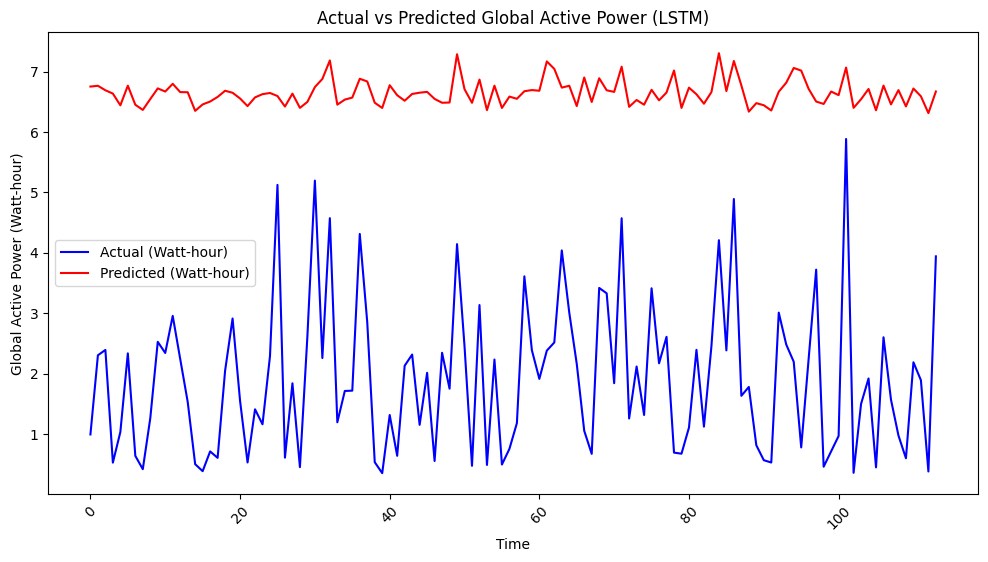

In [19]:
# Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Inverse transform the predictions and actual values
y_test_inv = scaler_y.inverse_transform(y_test_scaled).reshape(-1) * (100 / 60)
y_pred_test_inv = scaler_y.inverse_transform(y_pred_test).reshape(-1)

# Evaluate model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
mse = mean_squared_error(y_test_inv, y_pred_test_inv)
r2 = r2_score(y_test_inv, y_pred_test_inv)

print(f"LSTM - MAE: {mae}, MSE: {mse}, R²: {r2}")

# Plot predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('Actual vs Predicted Global Active Power (LSTM)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Creating a new feature to represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [ ]:
# Let's find out how many days have not been recoreded in our dataset
missing_days_df = np.round(full_df[['Global_active_energy']].resample('ME').count()/1440).astype(int)
missing_days_df.columns = ['Number of missing days']
missing_days_df['Number of missing days'] = missing_days_df.index.astype(str).str[-2:].astype(int) - missing_days_df['Number of missing days']
# Drop the rows where the number of missing days is 0
missing_days_df.drop(missing_days_df[missing_days_df['Number of missing days']==0].index,inplace=True)

# Drawing the plot
plt.figure(figsize=(15,7))
sns.barplot(
    data = missing_days_df,
    x = missing_days_df.index.date,
    y = missing_days_df.sort_values(by=['Number of missing days'],ascending=False)['Number of missing days']
)
plt.xticks(rotation = 90)
plt.yticks(np.arange(1,32,2))
plt.xlabel('')
plt.grid(axis='y')
plt.title('Missing Days Information',fontsize=20)
plt.show()

In [ ]:
import datetime
def plot_day_data(day:datetime.date) -> None:
    '''
    The function "plot_day_data" plots the "Global_active_energy" values 
    for a given date as input. The input date is used to filter the data
    and fill in any missing values with NaN. On the plot, the missing
    values are marked with markers. The X-axis displays xticks for the
    specified day and the Y-axis is labeled as "value". The final plot 
    is displayed using the matplotlib library.
    
    Parameters:
        day : datetime.date
        
    Return:
        None
    '''
    # Create time range and xtick for the day
    time_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='1min')
    xtick_range = pd.date_range(start='{}-{}-01'.format(day.year, day.month), end='{}-{}-{}'.format(day.year, day.month, day.day), freq='D')
    
    # Filter the data for the day and fill missing values with NaN
    tmp_df = full_df[['Global_active_energy']][full_df.index.isin(time_range)].copy()
    tmp_df = tmp_df.combine_first(pd.DataFrame(index=time_range, columns=tmp_df.columns))
    
    # Calculate the marker place
    marker_place = tmp_df[['Global_active_energy']].max().item() / 2
    # Identify the missing values
    missing_values = tmp_df.isna().any(axis=1)
    
    # Drawing the plot
    plt.figure(figsize=(15, 5))
    plt.plot(
        tmp_df[['Global_active_energy']][~missing_values],
        label = 'Normal Data'
    )
    plt.plot(
        tmp_df[['Global_active_energy']][missing_values].fillna(marker_place), 
        marker='o', 
        linestyle='None',
        label = 'Missing Data',
        color = 'r'
    )
    plt.xticks(xtick_range, rotation=90)
    plt.grid(axis='y')
    plt.title('Global_active_energy ({}:{})'.format(str(time_range[1].date()),str(time_range[-1].date())),fontsize=15)
    plt.ylabel('value')
    plt.legend()
    plt.show()
    
    return None
for day in missing_days_df.index.date:
    plot_day_data(day)

In [ ]:
f= plt.figure(figsize=(21,3))

ax=f.add_subplot(131)
dfm = full_df.resample('ME').mean()
sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Monthly resampling', size=12)

ax=f.add_subplot(132)
dfd = full_df.resample('D').mean()
sns.heatmap(dfd.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Daily resampling', size=12)
  
ax=f.add_subplot(133)
dfh = full_df.resample('h').mean()
sns.heatmap(dfh.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Hourly resampling', size=12)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(full_df['Global_active_power'], bins=50, kde=True)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kilowatt)')
plt.ylabel('Frequency')
plt.show()

## 2.1 Visualize Time Series Trends

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(full_df['Global_active_power'], label='Global Active Power')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatt)')
plt.title('Global Active Power Over Time')
plt.legend()
plt.show()

## 2.2 Check for Seasonality and Cyclical Patterns

In [ ]:
def check_seasonality_and_cyclical_patterns(df: pd.DataFrame):
    # Decompose the time series
    decomposition = seasonal_decompose(
        df["Global_active_power"].dropna(), model="additive", period=24 * 60
    )

    # Plot decomposition results
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label="Observed")
    plt.legend(loc="upper right")
    plt.subplot(412)
    plt.plot(decomposition.trend, label="Trend")
    plt.legend(loc="upper right")
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label="Seasonal")
    plt.legend(loc="upper right")
    plt.subplot(414)
    plt.plot(decomposition.resid, label="Residual")
    plt.legend(loc="upper right")
    plt.show()


check_seasonality_and_cyclical_patterns(full_df)

In [ ]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(full_df.resample('D').mean().values[:, col])
    plt.title(full_df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

## 2.3 Analyze Distribution of Power Consumption

In [ ]:
def analyze_distribution_of_power_consumption(df: pd.DataFrame):
    # Plot histogram
    plt.figure(figsize=(12, 6))
    df["Global_active_power"].hist(bins=50)
    plt.xlabel("Global Active Power (kilowatts)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Global Active Power")
    plt.show()

    # Plot boxplot
    plt.figure(figsize=(12, 6))
    df.boxplot(column="Global_active_power")
    plt.ylabel("Global Active Power (kilowatts)")
    plt.title("Boxplot of Global Active Power")
    plt.show()

analyze_distribution_of_power_consumption(full_df)

In [ ]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(full_df.resample('ME').mean().values[:, col])
    plt.title(full_df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
lag_plot(full_df['Global_active_power'])
plt.title('Lag Plot of Global Active Power')
plt.show()

# 3. Implement a linear regression model to predict power consumption for the last three time periods

In [ ]:
from src.task_2.models.linear_regression import run_linear_regression_e2e

In [ ]:
lr_results = run_linear_regression_e2e(full_df)

# 4. Evaluate the linear regression model using appropriate metrics

In [ ]:
print(json.dumps(lr_results, indent=1))

# 5. Implement a Recurrent Neural Network (RNN) for power consumption prediction

In [ ]:
from src.task_2.preprocessing.sequence import split_data_x_and_y

In [ ]:
# resample to reduce training time
df_resample = full_df.resample('h').mean() 
df_resample.shape

# create global scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_resample)

# split into X and y
X, y = split_data_x_and_y(df_resample)


In [ ]:
# Normalize data using the global scaler
scaled_X = scaler.fit_transform(X)
scaled_y = scaler.fit_transform(y.reshape(-1, 1))


In [ ]:
def create_sequences_x_and_y(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        a = data[i : (i + seq_length), 0]
        X.append(a)
        y.append(target[i + seq_length, 0])
    return np.array(X), np.array(y)


In [ ]:
t,z = create_sequences_x_and_y(scaled_X, scaled_y, 60)

In [ ]:
from src.task_2.models.rnn import build_rnn_model

model = build_rnn_model(60)

In [ ]:
model.fit(X_augmented, y_augmented, epochs=10, batch_size=64)

In [ ]:
from src.task_2.models.rnn import run_rnn_model_e2e

In [ ]:
rnn_results = run_rnn_model_e2e(df_resample)
print(json.dumps(rnn_results, indent=1))

# 6. Implement Long Short-Term Memory (LSTM) for power consumption prediction

In [ ]:
from src.task_2.models.long_short_term_memory import run_lstm_model_e2e

In [ ]:
run_lstm_model_e2e(df_resample)

# 7. Implement an LSTM model with an Attention layer for power consumption prediction

In [ ]:
from src.task_2.models.lstm_with_attention import run_lstm_model_with_attention_e2e

In [ ]:
run_lstm_model_with_attention_e2e(df_resample)

# 8. Data augmentation experiment

In [ ]:
from src.task_2.preprocessing.sequence import augment_sequence_data

In [ ]:
from src.task_2.data_modification.augmentation import add_noise
# Reshape input to be [samples, time steps, features]
t = t.reshape(t.shape[0], t.shape[1], 1)

# Augment the data with noise
X_augmented = add_noise(t)
# Labels remain the same
y_augmented = z  

In [ ]:
X_augmented, y_augmented = augment_sequence(df_resample, sequence_length=60)

In [ ]:
from src.task_2.models.rnn import build_rnn_model
rnn_model = build_rnn_model(60)
history = rnn_model.fit(X_augmented, y_augmented, epochs=10, batch_size=64, verbose=1, callbacks=[early_stopping])

# 9. Data reduction experiment

In [ ]:
from src.task_2.data_modification.augmentation import reduce_data_randomly

In [ ]:
# Apply reduction
X_reduced, y_reduced = reduce_data_randomly(X, y, reduction_factor=0.1)

# 10. Data resolution experiment

In [ ]:
from data_modification.resolution import resample_data_from_1min_to_2min

In [ ]:
resampled_df = resample_data_from_1min_to_2min(full_df)

In [ ]:
# Define the target variable and features
features = ['Global_active_power_wh', 'active_energy_without_subs', 'lag_1']
target = ['Global_active_power_wh']

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(0, len(data) - sequence_length, sequence_length):
        seq = data[features].iloc[i:i + sequence_length].values
        label = data[target].iloc[i + sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

sequence_length = 12
sequences, targets = create_sequences(df_10_percent, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Scale the features and target separately
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


# Design the RNN model
rnn_model = Sequential()
rnn_model.add(layers.SimpleRNN(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
rnn_model.add(layers.BatchNormalization())
rnn_model.add(layers.Dropout(0.2))
rnn_model.add(layers.Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')

# Define early stopping
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)

# Train the RNN model
rnn_history = rnn_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=2, shuffle=False, callbacks=[early_stopping])

plot_training_history(rnn_history)

# Make predictions with the RNN model
y_pred_train_rnn = rnn_model.predict(X_train_scaled)
y_pred_test_rnn = rnn_model.predict(X_test_scaled)

# Inverse transform the predictions and actual values
y_pred_train_rnn_inv = scaler_y.inverse_transform(y_pred_train_rnn).reshape(-1)
y_pred_test_rnn_inv = scaler_y.inverse_transform(y_pred_test_rnn).reshape(-1)
y_train_inv = scaler_y.inverse_transform(y_train_scaled).reshape(-1)
y_test_inv = scaler_y.inverse_transform(y_test_scaled).reshape(-1)

# Evaluate RNN model performance
mae_rnn = mean_absolute_error(y_test_inv, y_pred_test_rnn_inv)
mse_rnn = mean_squared_error(y_test_inv, y_pred_test_rnn_inv)
r2_rnn = r2_score(y_test_inv, y_pred_test_rnn_inv)

print(f"RNN - MAE: {mae_rnn}, MSE: {mse_rnn}, R²: {r2_rnn}")

# Plot RNN predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual (Watt-hour)', color='blue')
plt.plot(y_pred_test_rnn_inv, label='Predicted (Watt-hour)', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (Watt-hour)')
plt.title('Actual vs Predicted Global Active Power (RNN)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 11. Conclusion and insights